
\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# 1. {-}

## 1.1 {-}

In [51]:
import pandas as pd
from sklearn.preprocessing import Normalizer

stock = pd.read_csv('stocksample.txt', sep='\t', index_col='symb')
stock = stock.iloc[:, 3:].T
stock = ((stock - stock.mean())/stock.std()).T
stock.head()

,2017-08-18,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-28,2017-08-29,2017-08-30,2017-08-31,...,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29
symb,,,,,,,,,,,,,,,,,,,,,
NEWM,-1.042968,-1.093516,-0.461669,-0.916599,-0.714408,-0.512217,-0.360574,-0.588039,-0.310026,-0.310026,...,-0.208931,-0.183657,0.271273,0.347094,0.751476,1.484419,1.762431,2.065717,2.293182,2.217361
DMO,1.242230,1.457314,2.717065,1.430735,0.469868,0.686838,0.593853,1.120778,1.337757,1.244769,...,-0.986926,-1.048917,-0.893947,-0.753228,-0.534328,-0.721953,-0.659413,-1.034664,-0.784496,-0.190345
VMW,-2.564541,-2.379633,-1.650002,-1.535060,-1.425114,-0.947856,-0.463100,-0.400631,0.106613,0.391469,...,0.861233,0.786270,0.898713,0.633847,0.653838,0.246542,0.324004,0.668829,0.666330,0.663833
CCI,-0.342359,-0.046708,0.332222,0.482130,0.748633,0.852734,0.877722,0.865228,0.969329,1.456531,...,0.209164,-0.769930,-0.904402,-1.005252,-1.425465,-1.622966,-1.858284,-1.681795,-1.450677,-1.685995
MNK,-0.070881,-0.201274,0.295225,0.340361,0.861937,1.243087,1.228043,1.308285,1.423633,2.281225,...,-1.389865,-1.234395,-1.023758,-0.838198,-0.853243,-0.642607,-0.933487,-0.572396,-0.196260,0.420603


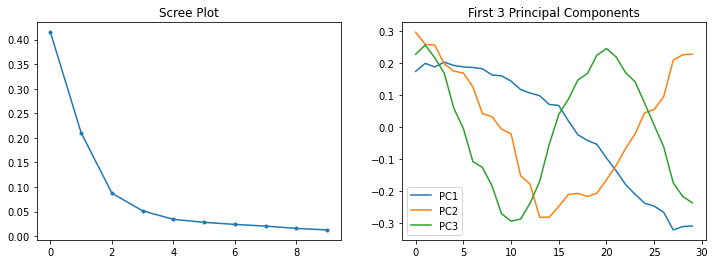

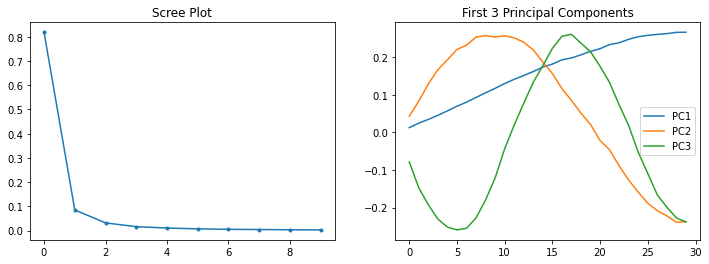

In [7]:
from scipy.stats import norm
from pandas import DataFrame, Series
from sklearn.decomposition import PCA
import numpy as np

np.random.seed(0)
random_walk = DataFrame([norm.rvs(size=30).cumsum() for _ in range(1000)])

def pca_plots(data):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    pcaout = PCA(n_components=10).fit(data)
    Series(pcaout.explained_variance_ratio_).plot(style='.-', ax=ax[0])
    DataFrame(pcaout.components_[:3].T, columns=['PC1', 'PC2', 'PC3']).plot(ax=ax[1])
    
    ax[0].set_title('Scree Plot')
    ax[1].set_title('First 3 Principal Components')
    plt.show()

pca_plots(stock)    
pca_plots(random_walk)

# 2. {-}

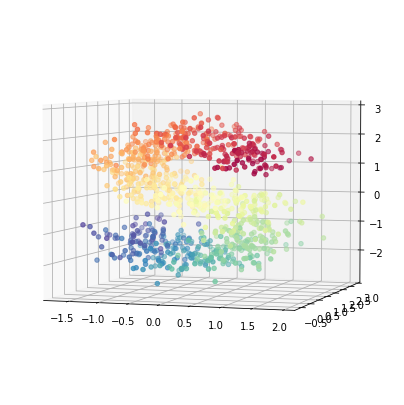

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

n_points = 1000
Scurve, Scolor = datasets.make_s_curve(n_points, random_state=0)
noise = np.matrix(np.random.normal(0, .3, 3000)).reshape(1000,3)
Snoise = Scurve + noise

fig = plt.figure(figsize=(7, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Snoise[:, 0], Snoise[:, 1], Snoise[:, 2], c=Scolor, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.show()

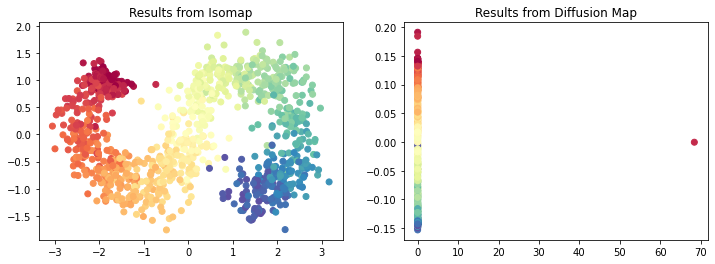

In [21]:
from pydiffmap import diffusion_map as dm
from sklearn import manifold

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

dmap = dm.DiffusionMap.from_sklearn(n_evecs=3, epsilon="bgh")
Snoisediffmap = dmap.fit_transform(Snoise)
Y = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(Snoise)

ax[0].scatter(Y[:, 0], Y[:, 1], c=Scolor, cmap=plt.cm.Spectral)
ax[0].set(title='Results from Isomap')

ax[1].scatter(Snoisediffmap[:, 0], Snoisediffmap[:, 1], c=Scolor, cmap=plt.cm.Spectral)
ax[1].set(title='Results from Diffusion Map')
plt.show()

# 3. {-}

In [52]:
stock = stock.T
stock.describe()[1:3]

symb,NEWM,DMO,VMW,CCI,MNK,CMD,MTU,XIN,INB,BOX,...,LL,RRD,OUT,VNTR,GWW,XNY,FLY,JGH,MPO,GIS
mean,4.914587e-15,-6.328271e-15,-4.141132e-15,-2.760755e-15,-2.379578e-15,-2.427688e-15,7.993606e-15,-2.146431e-15,4.124108e-14,-7.438494e-16,...,-2.164935e-15,2.442491e-15,4.500104e-15,3.922788e-16,-1.332268e-16,2.181588e-15,1.273056e-15,4.101904e-14,6.476301e-16,3.523108e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [53]:
# stock = stock.iloc[:, :5]

In [54]:
stock['dateIdx'] = range(30)

In [55]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
%%R -i stock -o optspan

library(fANCOVA)

optspan <- list()

for (ticker in colnames(stock))
{
    holdlo = loess.as(stock$dateIdx, stock[[ticker]], criterion='aicc')
    optspan[[ticker]] <- holdlo$pars$span
}

In [57]:
stock.drop('dateIdx', axis='columns', inplace=True)

In [58]:
span = {k: 1-0.9*(1-v[0]) for k, v in optspan.items()}

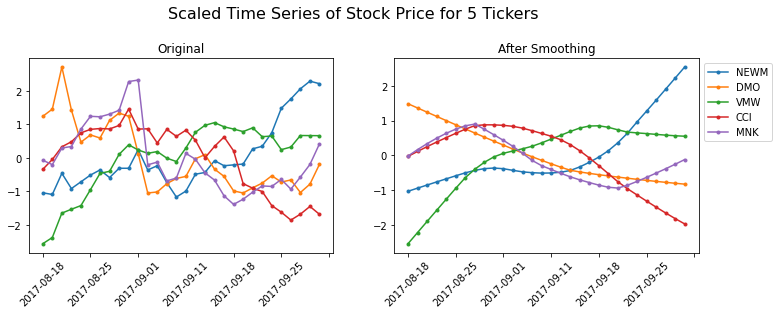

In [65]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import DataFrame

smooth = DataFrame(index=stock.index)

for ticker in stock.columns:
    lowout = sm.nonparametric.lowess(stock[ticker], range(30), frac=span[ticker])
    smooth[ticker] = lowout[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
stock.iloc[:, :5].plot(style='.-', rot=45, ax=ax[0], legend=None, title='Original')
smooth.iloc[:, :5].plot(style='.-', rot=45, ax=ax[1], legend=None, title='After Smoothing')

plt.suptitle('Scaled Time Series of Stock Price for 5 Tickers', fontsize=16)
plt.subplots_adjust(top=0.80)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [60]:
# smooth.T.to_csv('stocksmooth.csv')

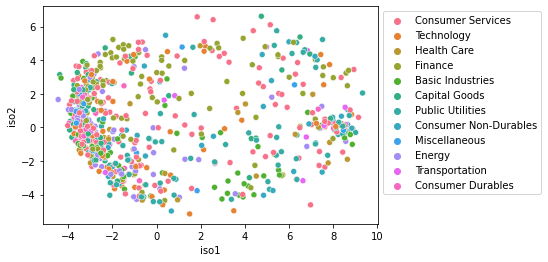

In [17]:
from pandas import DataFrame
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

smooth = pd.read_csv('stocksmooth.csv', index_col=0)
isoout = DataFrame(
    manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(smooth), 
#     columns=['iso1', 'iso2', 'iso3', 'iso4', 'iso5'])
    columns=['iso1', 'iso2'])
isoout['sector'] = pd.read_csv('stocksample.txt', sep='\t', index_col='symb')['sector'].values

sns.scatterplot(x='iso1', y='iso2', data=isoout, hue='sector')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()
